In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
import yfinance as yf 


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4663,18-12-2023,29.0369
4664,19-12-2023,29.0576
4665,20-12-2023,29.0822
4666,21-12-2023,29.1201


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [6]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


In [7]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [8]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


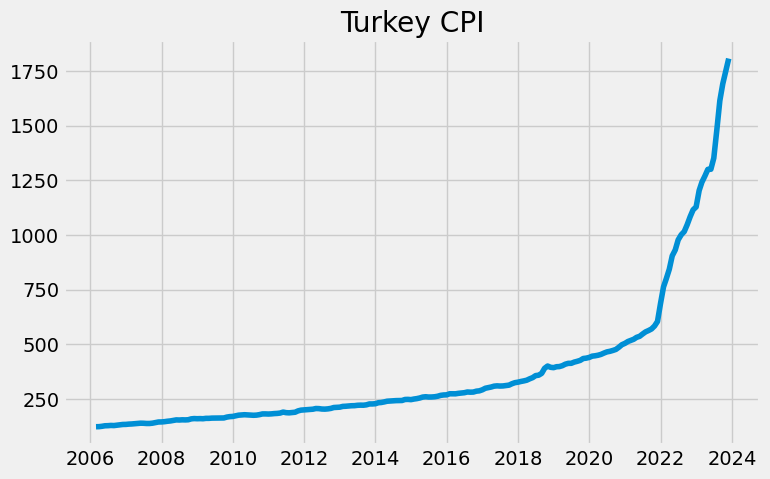

In [9]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28',periods=len(money), freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-08-31,120.253200
2023-09-30,123.493100
2023-10-31,127.637895
2023-11-30,130.504631


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-08-31,123.434020
2023-09-30,126.661059
2023-10-31,130.934676
2023-11-30,134.161244


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0


In [14]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-08-31,85.104348
2023-09-30,92.766499
2023-10-31,88.704091


In [15]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10
213,2023-11,1.078661e+10


In [16]:
dates=pd.date_range('2006-02-01',periods=len(kredi) , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503
213,2023-11,107.866144


In [17]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144


In [18]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09


In [19]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00


In [20]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61


In [21]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-06-30,180.070938,186.192371,179.437348
2023-07-31,191.652101,194.142558,184.796934
2023-08-31,185.107822,183.341634,176.289202
2023-09-30,184.891859,183.368030,175.221191


In [22]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [23]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-06-30,148.238298
2023-07-31,147.640395
2023-08-31,146.465496
2023-09-30,146.342705


In [24]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-08-31,30.76
2023-09-30,42.74
2023-10-31,41.72
2023-11-30,46.07


In [25]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [26]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09


In [27]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-07-31,81.62
2023-08-31,85.39
2023-09-30,89.35
2023-10-31,89.16


In [28]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-07-31,48.71
2023-08-31,52.42
2023-09-30,55.55
2023-10-31,56.01


In [29]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"][:-1].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,Borç,TÜFE
Tarih,,,,,,,,,
2010-02-28,0.574311,-0.468328,-0.470323,0.935668,2.358713,2.473323,-0.317515,1.774400,1.447693
2010-03-31,0.644001,1.850070,2.622296,1.971218,1.929881,2.894349,1.831928,1.064192,0.583272
2010-04-30,0.478728,1.038067,0.713406,0.918462,1.021775,3.033220,0.969354,0.366513,0.596780
2010-05-31,0.646630,0.240025,-0.856462,0.610769,2.763430,3.592510,0.095471,0.729264,-0.358182
2010-06-30,0.922501,1.537408,-0.175370,-0.094972,0.563442,3.358199,1.609402,-0.769974,-0.561672
...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.986884,-0.403339,5.675617,15.439600,9.689321,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.603827,-0.795784,1.850455,5.968276,2.618269,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.605829,-0.083836,2.080815,4.845313,4.384930,4.753114


In [30]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,8.85,91.32,95.75,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.75,93.31,96.63,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.65,93.75,97.25,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,10.75,98.14,102.98,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.43,99.40,105.10,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,7.066073,16.807611,-0.151044,38.78,0.00,1.117934,7.55,-1.017069,2.406884,5.711697,41.98,87.02,51.59,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.986884,44.58,34.00,-0.403339,7.70,15.146856,9.689321,5.675617,29.32,81.62,48.71,15.439600,9.3,17.50,9.488824
2023-08-31,10.505114,26.763908,-4.603827,45.29,0.00,-0.795784,6.81,5.943431,2.618269,1.850455,30.76,85.39,52.42,5.968276,9.1,23.50,9.086793


In [31]:
data.to_csv('data.csv')

In [32]:
features=["USD/TL","Motorin","Enflasyon Belirsizliği","ParaArzi","Kredi Faizi","TÜFE"]
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [34]:
test_period = 3 
test_size = test_period   

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırın
X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values

In [35]:
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
keras.utils.set_random_seed(1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])


Epoch 1/500
4/4 [==============================] - 3s 153ms/step - loss: 4.6707 - val_loss: 0.9604
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.2287 - val_loss: 0.1489
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0199 - val_loss: 0.0694
Epoch 4/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0128 - val_loss: 0.0647
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0122 - val_loss: 0.0570
Epoch 6/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0595
Epoch 7/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0113 - val_loss: 0.0486
Epoch 8/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0225
Epoch 9/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0148 - val_loss: 0.0110
Epoch 10/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0642 - val_loss: 0.0166
Epoch 11/500
4/4 [

In [36]:
'''import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid

# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)

# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlayın
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}

best_rmse = float('inf')
best_params = None

# Grid Search yapın
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# En iyi hiperparametreleri ve sonuçları görüntüleyin
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)'''


'import numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.metrics import make_scorer, mean_squared_error\nfrom sklearn.model_selection import ParameterGrid\n\n# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)\n\n# Model fonksiyonunu tanımlayın\ndef create_model(neurons=128, activation=\'relu\', optimizer=\'adam\', epochs=100):\n    model = Sequential()\n    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))\n    model.add(Dense(1))\n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)\n    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])\n    return model\n\n\n# Grid Search için hiperparametre kombinasyonlarını tanımlayın\nparam_grid = {\n    \'neurons\'

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerinizi yapın
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplayın
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 299ms/step
Validation MSE: 0.0007491616295059077
Validation RMSE: 0.027370817114326488


In [38]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

0.41106615023290005

In [39]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669236
Enflasyon Belirsizliği    0.624443
Kredi                     0.521249
Kredi Faizi               0.520287
Borç                      0.450264
Mevduat Faizi             0.423982
Zam                       0.407074
Politika Faizi            0.225434
Sanayi                   -0.049493
Perakende Satış          -0.113209
İşsizlik                 -0.194010
REDK                     -0.388566
REDKT                    -0.578101
Name: TÜFE, dtype: float64

In [40]:
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)

In [41]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'REDK', 'REDKT', 'M3', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)
best_mse=float("inf")
best_features=[]
for r in range(5,13):
   for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        model = sm.RLM(y_train, X_train_subset, M=sm.robust.norms.HuberT())
        results = model.fit()
        y_pred=results.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(scalery.inverse_transform(np.array(y_test).reshape(-1,1)),scalery.inverse_transform(np.array(y_pred).reshape(-1,1))))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import StandardScaler,MinMaxScaler\nfeatures=[\'USD/TL\', \'Motorin\', \'Perakende Satış\', \'Zam\', \'Sanayi\',\n       \'Enflasyon Belirsizliği\', \'ParaArzi\', \'Borç\', \'Kredi\', \'Mevduat Faizi\',\n       \'REDK\', \'REDKT\', \'M3\', \'İşsizlik\', \'Politika Faizi\']\nX=data[features]\ny=data[["TÜFE"]]\nscalerX = StandardScaler().fit(X)\nscalery = StandardScaler().fit(y)\nX_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]\nX_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)\ny_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)\nX_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)\ny_test = pd.DataFrame(scalery.transform(y_test),y.index[-

In [42]:
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)
model=LinearRegression().fit(X_train,y_train)
pred=model.predict(X_test)
rmse=[]
tahminler=pd.DataFrame(scalery.inverse_transform(y_test),index=X.index[-3:],columns=["Aylık Enflasyon"])
tahminler["Linear Regression"]=scalery.inverse_transform(pred)
rmse=[]
rmse.append(np.sqrt(mean_squared_error(scalery.inverse_transform(y_test),scalery.inverse_transform(pred))))

In [43]:
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
results = model.fit()
pred=results.predict(X_test)
pred=np.array(pred).reshape(-1,1)
tahminler["Robust Regression"]=scalery.inverse_transform(pred)
rmse.append(np.sqrt(mean_squared_error(scalery.inverse_transform(y_test),scalery.inverse_transform(pred))))

In [44]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [45]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [46]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [47]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [48]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [49]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [50]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [51]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Gaussian Regression,0.144171
Kernel Regression,0.239396
Linear Regression,0.243196
SGD Regressor,0.387107
LSTM,0.411066
Bayesian Regression,0.442063
Lasso Regression,0.484714
Robust Regression,0.597282
Lars Regression,0.662000


In [52]:
tahminler.index.strftime("%Y-%m")

Index(['2023-08', '2023-09', '2023-10'], dtype='object', name='Tarih')

In [53]:
tahminler=tahminler.set_index(pd.date_range(start="2023-08",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")


<Axes: >

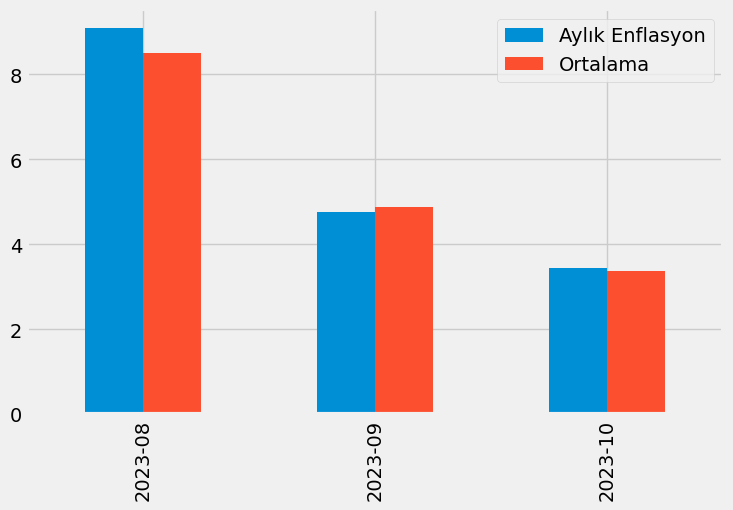

In [54]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

In [55]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(13)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [56]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.290000
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,59.530000
2024-01-31,59.851654
2024-02-29,59.964112
2024-03-31,60.003430
2024-04-30,60.017176
2024-05-31,60.021983


In [57]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-06-30,38.78
2023-07-31,44.58
2023-08-31,45.29
2023-09-30,57.56


In [58]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,59.530000
2024-01-31,59.851654
2024-02-29,59.964112
2024-03-31,60.003430
2024-04-30,60.017176
2024-05-31,60.021983
2024-06-30,60.023663
2024-07-31,60.024250


In [59]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(13,X=faiztahmin[5:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2023-11-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-11-30,46.070000
2023-12-31,52.170000
2024-01-31,53.302938
2024-02-29,51.170984
2024-03-31,52.815021
2024-04-30,52.842752
2024-05-31,52.121114
2024-06-30,52.499256
2024-07-31,52.605040
2024-08-31,52.385326


In [60]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [61]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077


In [62]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,40
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [63]:
faiztahmin.columns=["Faiz"]


In [64]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [65]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [66]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [67]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(16,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-11-30,8.540840
2023-12-31,8.454193
2024-01-31,8.347127
2024-02-29,8.364339
2024-03-31,8.439923
2024-04-30,8.466738
2024-05-31,8.534691
2024-06-30,8.602699
2024-07-31,8.653981
2024-08-31,8.715422


In [68]:
from prophet import Prophet


In [69]:
df6.shape

(215, 1)

In [70]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,500)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,500)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params

In [71]:
'''study.best_params'''

'study.best_params'

In [72]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
sn["cap"]=285.7233032513667
prophet=Prophet(growth="linear",changepoint_prior_scale=4.913477926048151,changepoint_range=0.8995647346860385,seasonality_prior_scale=5.929453787047488,n_changepoints=24,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=285.7233032513667
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:41:39 - cmdstanpy - INFO - Chain [1] start processing
13:41:40 - cmdstanpy - INFO - Chain [1] done processing


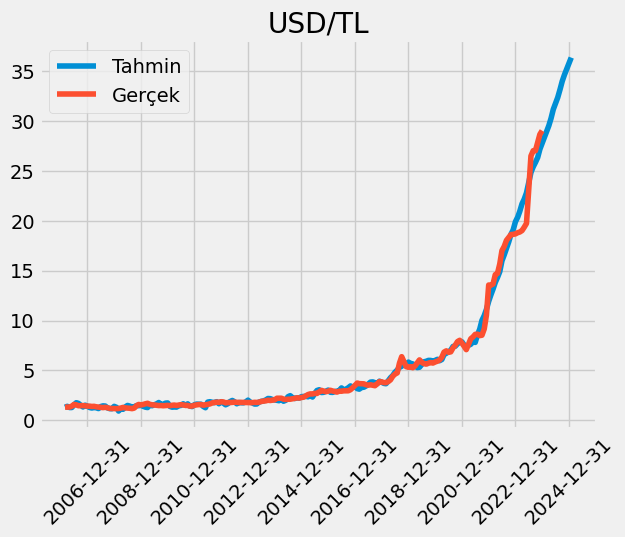

In [73]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(predictions.index[10::24],rotation=45)
plt.legend()
plt.show()

In [74]:
usdtahmin=(predictions["yhat"][-14:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-01-31    2.233343
2024-02-29    2.024981
2024-03-31    1.913727
2024-04-30    2.452170
2024-05-31    3.008411
2024-06-30    1.915034
2024-07-31    1.898619
2024-08-31    2.454729
2024-09-30    2.486735
2024-10-31    1.942660
2024-11-30    1.635223
2024-12-31    1.656200
2025-01-31    1.569181
Name: yhat, dtype: float64

In [75]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-5:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", end="2025-02-27", freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.001238
2024-01-31,29.648935
2024-02-29,30.249320
2024-03-31,30.828209
2024-04-30,31.584170
2024-05-31,32.534351


In [76]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'm':trial.suggest_int('m',0,180),
                'cap':trial.suggest_int('cap',1,1000)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[params["m"]:-12].index
    sn["y"]=df14[params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df14["Brent"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'m\':trial.suggest_int(\'m\',0,180),\n                \'cap\':trial.suggest_int(\'cap\',1,1000)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[params["m"]:-12].index\n    sn["y"]=df14[params["m"]:-12].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    future_dates["cap"]=params["cap"]\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(

In [77]:
#study.best_params

In [78]:
sn=pd.DataFrame()
sn["ds"]=df14[51:].index
sn["y"]=df14[51:].values
sn["cap"]=741
prophet=Prophet(growth="logistic",changepoint_prior_scale=9.40940230511886,changepoint_range=0.26678385022653445)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=741
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:41:40 - cmdstanpy - INFO - Chain [1] start processing


13:41:41 - cmdstanpy - INFO - Chain [1] done processing


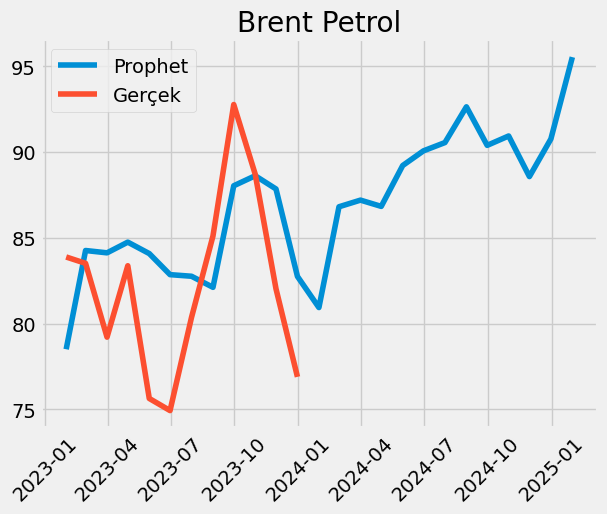

In [79]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [80]:
'''from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme
layer_units = [64, 128]  # LSTM katmanındaki nöron sayısı
dense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı
activations = ['relu', 'tanh','sigmoid','elu','selu']  # Aktivasyon fonksiyonları
learning_rates = [0.001, 0.01]  # Öğrenme hızı
optimizers = ['adam', 'sgd']  # Optimizer'lar

best_mse = float('inf')
best_model = None

for lstm_units in layer_units:
    for dense_unit in dense_units:
        for activation in activations:
            for learning_rate in learning_rates:
                for optimizer_name in optimizers:
                    try:
                        # Modeli oluşturma
                        model = Sequential()
                        model.add(LSTM(units=lstm_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dense(units=dense_unit, activation=activation))
                        model.add(Dense(units=1))
                        
                        # Optimizer'ı ve learning rate'i ayarlama
                        if optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':
                            optimizer = SGD(learning_rate=learning_rate)  # SGD için gerekirse import etmeyi unutmayın
                        
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        
                        # Modeli eğitme ve early stopping uygulama
                        model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)
                        
                        # Modeli değerlendirme
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
                        
                        # En iyi modeli güncelleme
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                    except Exception as e:
                        print(f'Hata oluştu: {e}')

# En iyi modelin MSE değerini ve kullanılan optimizer'ı yazdırma
print(f'En İyi Modelin Ortalama Kare Hatası (MSE): {best_mse}')
if best_model is not None:
    print(f'En İyi Modelde Kullanılan Optimizer: {best_model.optimizer.get_config()["name"]}')
'''

'from sklearn.model_selection import train_test_split\nfrom tensorflow.keras.optimizers import Adam,SGD\nfrom tensorflow.keras.callbacks import EarlyStopping\n\ntrain_size=-12\n# Veriyi eğitim ve test setlerine bölme\n\nX_train, X_test = X[:train_size], X[train_size:]\ny_train, y_test = y[:train_size], y[train_size:]\n\n# Early stopping\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=10, restore_best_weights=True)\n\n# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme\nlayer_units = [64, 128]  # LSTM katmanındaki nöron sayısı\ndense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı\nactivations = [\'relu\', \'tanh\',\'sigmoid\',\'elu\',\'selu\']  # Aktivasyon fonksiyonları\nlearning_rates = [0.001, 0.01]  # Öğrenme hızı\noptimizers = [\'adam\', \'sgd\']  # Optimizer\'lar\n\nbest_mse = float(\'inf\')\nbest_model = None\n\nfor lstm_units in layer_units:\n    for dense_unit in dense_units:\n        for activation in activations:\n  

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
keras.utils.set_random_seed(7)
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=16, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 57ms/step - loss: 0.1923 - val_loss: 0.1956
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0810 - val_loss: 0.0168
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0699 - val_loss: 0.0626
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0614 - val_loss: 0.0281
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0566 - val_loss: 0.0394
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0539 - val_loss: 0.0309
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0538 - val_loss: 0.0345
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0542 - val_loss: 0.0533
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0490 - val_loss: 0.0171
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0466 - val_loss: 0.0493

1/1 [==============================] - 0s 350ms/step


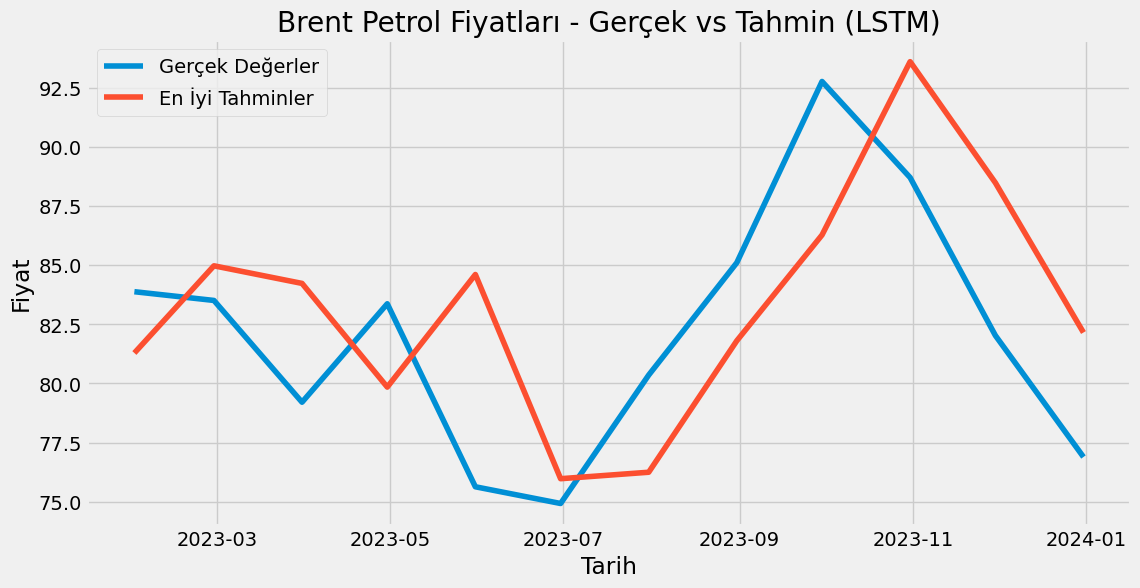

In [82]:
pred=scaler.inverse_transform(model.predict(X_test))
plt.figure(figsize=(12, 6))
plt.plot(df14.index[-len(y_test):], scaler.inverse_transform(y_test), label='Gerçek Değerler')
plt.plot(df14.index[-len(y_test):], pred, label='En İyi Tahminler')
plt.title('Brent Petrol Fiyatları - Gerçek vs Tahmin (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [83]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [84]:
# generate the input and output sequences
n_lookback = 13  # length of input sequences (lookback period)
n_forecast = 13  # length of output sequences (forecast period)
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
keras.utils.set_random_seed(0)
# fit the model
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(units=16, activation='sigmoid'))  # Dense katmanı eklendi
model.add(Dense(units=1))  # Çıkış birimi sayısını 1 olarak değiştirildi

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=1)

# generate the forecasts
X_ = y[-n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

# Tahmin yaparken çıkış şeklini düzenle
Y_ = model.predict(X_).reshape(1, n_forecast)

# Orijinal ölçekleme işlemi
Y_ = scaler.inverse_transform(Y_)

print(Y_)



Epoch 1/100
11/11 [==============================] - 2s 11ms/step - loss: 0.4252
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1112
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0813
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0702
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0668
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0641
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0624
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0608
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0607
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0589
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0577
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0576
Epoch 13/100
11/11 [============

In [85]:
Y_=np.array(Y_).reshape(-1,1)

In [86]:
future=pd.DataFrame()
future["Brent"]=df14["Brent"]
Y_=pd.DataFrame(Y_)
Y_.columns=["Brent"]
Y_=Y_.set_index(pd.date_range(start="2024-01-31",periods=13,freq="M"))
future=pd.concat([future,Y_],axis=0)
future

,Brent
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-09-30,76.828186
2024-10-31,79.161201
2024-11-30,78.450035
2024-12-31,76.490120


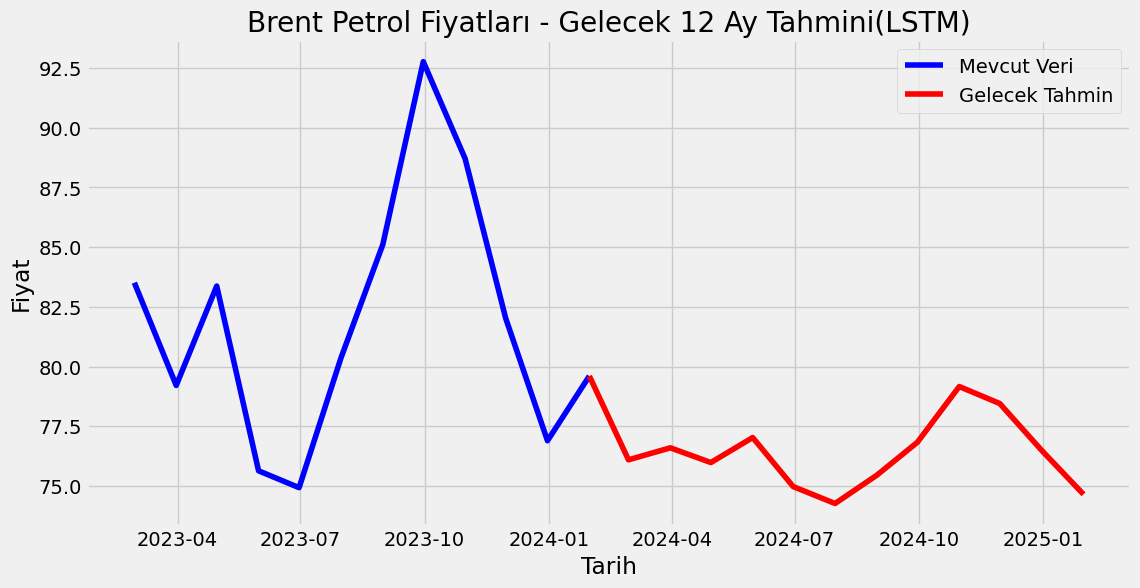

In [87]:
plt.figure(figsize=(12, 6))
#plt.plot(pred,label='Test Tahmini',color='green')
plt.plot(future["Brent"][-24:-12], label='Mevcut Veri',color='blue')
plt.plot(future["Brent"][-13:] ,label='Gelecek Tahmin',color='red')
plt.title('Brent Petrol Fiyatları - Gelecek 12 Ay Tahmini(LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [88]:
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [89]:
enf_belirsizlik["Enflasyon Belirsizliği"][-12:]

2023-01-31    9.44
2023-02-28    7.31
2023-03-31    7.59
2023-04-30    7.51
2023-05-31    7.37
2023-06-30    7.55
2023-07-31    7.70
2023-08-31    6.81
2023-09-30    7.30
2023-10-31    5.57
2023-11-30    4.49
2023-12-31    3.36
Freq: M, Name: Enflasyon Belirsizliği, dtype: float64

In [90]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.0001,0.9999),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400),
                'm':trial.suggest_int('m',0,105)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[params["m"]:].index
    sn["y"]=enf_belirsizlik[params["m"]:].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.0001,0.9999),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400),\n                \'m\':trial.suggest_int(\'m\',0,105)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik[params["m"]:].index\n    sn["y"]=en

In [91]:
model=auto_arima(enf_belirsizlik,trace=False,information_criterion='aic',seasonal=True,m=5)
enfbelirsizliktahmin1=model.predict(13)
enfbelirsizliktahmin1=pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-1:,0]},index=pd.date_range(start="2023-12-30",periods=1,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1


,Enflasyon Belirsizliği
2023-12-31,3.360000
2024-01-31,2.395268
2024-02-29,2.705154
2024-03-31,2.729013
2024-04-30,2.666159
2024-05-31,1.887541
2024-06-30,1.270527
2024-07-31,1.320320
2024-08-31,1.879789
2024-09-30,2.188238


In [92]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [93]:
#study.best_params

In [94]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=16,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:26 - cmdstanpy - INFO - Chain [1] start processing


13:42:26 - cmdstanpy - INFO - Chain [1] done processing


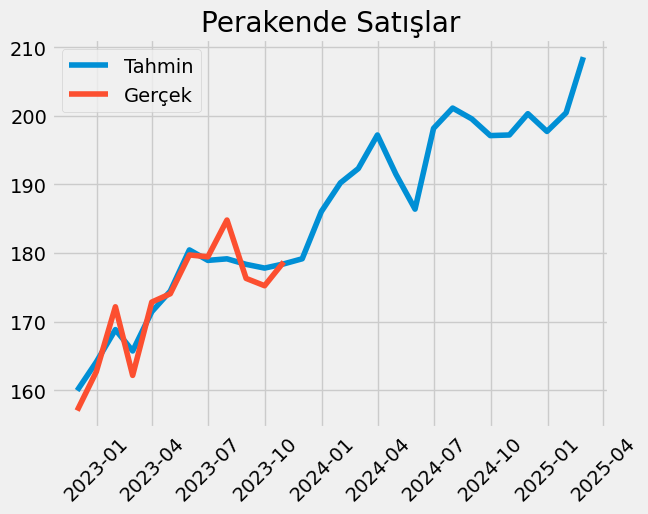

In [95]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [96]:
perakendetahmin=(predictions["yhat"][-29:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2022-11-30    3.216423
2022-12-31    2.596770
2023-01-31    2.882036
2023-02-28   -1.843518
2023-03-31    3.450989
2023-04-30    1.752146
2023-05-31    3.443678
2023-06-30   -0.845366
2023-07-31    0.126571
2023-08-31   -0.448943
2023-09-30   -0.306626
2023-10-31    0.344698
2023-11-30    0.417766
2023-12-31    3.837414
2024-01-31    2.255112
2024-02-29    1.093496
2024-03-31    2.545369
2024-04-30   -2.901185
2024-05-31   -2.657283
2024-06-30    6.315988
2024-07-31    1.493700
2024-08-31   -0.782232
2024-09-30   -1.221874
2024-10-31    0.044657
2024-11-30    1.575699
2024-12-31   -1.293369
2025-01-31    1.373530
2025-02-28    4.050079
Name: yhat, dtype: float64

In [97]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((future[-16:].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-5.069884
2024-01-31,5.837052
2024-02-29,-2.473690
2024-03-31,2.587696
2024-04-30,1.626967
2024-05-31,4.428495
2024-06-30,-0.803615
2024-07-31,0.936859
2024-08-31,4.092941


In [98]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"][params["m"]:-12].index
    sn["y"]=money["Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"][params["m"]:-12].index\n    sn["y"]=money["Para Arzi"][

In [99]:
#study.best_params

In [100]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"][110:].index
sn["y"]=money["Para Arzi"][110:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=0.17670782903839727,changepoint_range=0.8995442051379563,growth='linear',seasonality_prior_scale=9.026889153868014)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:26 - cmdstanpy - INFO - Chain [1] start processing
13:42:27 - cmdstanpy - INFO - Chain [1] done processing


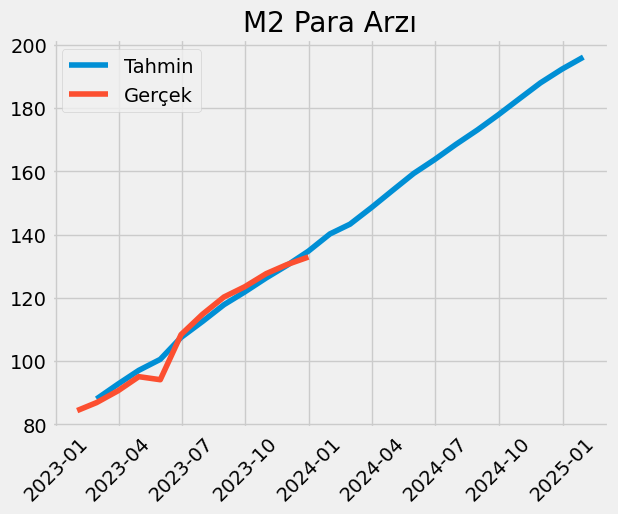

In [101]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"][-24:],label="Tahmin")
plt.plot(money["Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [102]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(13)
paraarzitahmin

ds
2024-01-31    4.033778
2024-02-29    2.201972
2024-03-31    3.665655
2024-04-30    3.593094
2024-05-31    3.546345
2024-06-30    2.731369
2024-07-31    2.958223
2024-08-31    2.707098
2024-09-30    2.750057
2024-10-31    2.903384
2024-11-30    2.708868
2024-12-31    2.304500
2025-01-31    1.985674
Name: yhat, dtype: float64

In [103]:
paraarzitahmin1 = []
result = money.iloc[-1,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-01-30", end="2025-02-27", freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-09-30,123.493100
2023-10-31,127.637895
2023-11-30,130.504631
2023-12-31,132.899089
2024-01-31,138.259943
2024-02-29,141.304388
2024-03-31,146.484120
2024-04-30,151.747433
2024-05-31,157.128920
2024-06-30,161.420690


In [104]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [105]:
#study.best_params

In [106]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=15,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:27 - cmdstanpy - INFO - Chain [1] start processing
13:42:27 - cmdstanpy - INFO - Chain [1] done processing


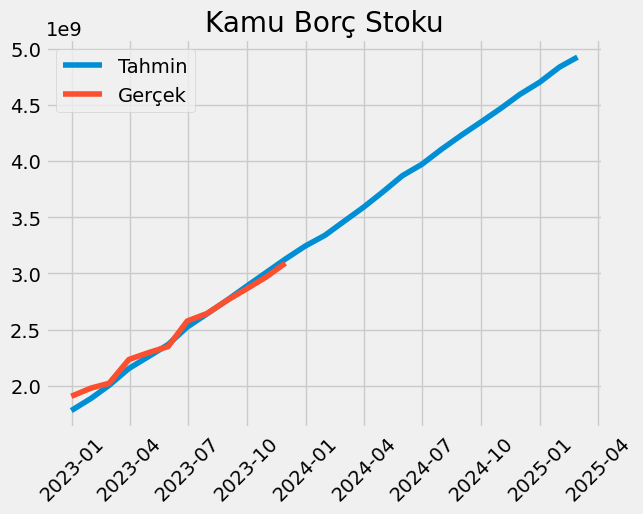

In [107]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [108]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(15)
borctahmin

ds
2023-12-31    3.705704
2024-01-31    2.972785
2024-02-29    3.625007
2024-03-31    3.701697
2024-04-30    3.780794
2024-05-31    3.939096
2024-06-30    2.571142
2024-07-31    3.410988
2024-08-31    3.048816
2024-09-30    2.722594
2024-10-31    2.795456
2024-11-30    2.810203
2024-12-31    2.363101
2025-01-31    2.877330
2025-02-28    1.826090
Name: yhat, dtype: float64

In [109]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-07-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-07-31,NaN
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.205260e+09
2023-12-31,3.300545e+09
2024-01-31,3.420190e+09
2024-02-29,3.546795e+09
2024-03-31,3.680892e+09
2024-04-30,3.825886e+09


In [110]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"][params["m"]:-12].index
    sn["y"]=df3["Kredi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"][params["m"]:-12].index\n    sn["y"]=df3["Kredi"][params["m"]:

In [111]:
#study.best_params

In [112]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"][150:].index
sn["y"]=df3["Kredi"][150:].values
sn["cap"]=381.79609705677035
prophet=Prophet(changepoint_prior_scale=2.10520609698171,changepoint_range=0.6734967268169046,growth='logistic',seasonality_prior_scale=4.921223978299016,n_changepoints=6,yearly_seasonality=True,weekly_seasonality='auto')

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=381.79609705677035
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:28 - cmdstanpy - INFO - Chain [1] start processing


13:42:28 - cmdstanpy - INFO - Chain [1] done processing


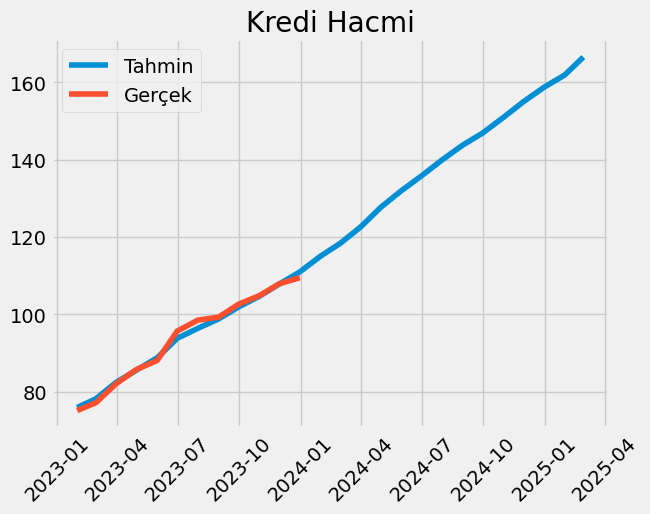

In [113]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(df3["Kredi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [114]:
kreditahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(14)
kreditahmin

ds
2024-01-31    3.661791
2024-02-29    2.819511
2024-03-31    3.618241
2024-04-30    4.127820
2024-05-31    3.384677
2024-06-30    2.880811
2024-07-31    3.052950
2024-08-31    2.749624
2024-09-30    2.181079
2024-10-31    2.738736
2024-11-30    2.688925
2024-12-31    2.424721
2025-01-31    1.998600
2025-02-28    2.856669
Name: yhat, dtype: float64

In [115]:
kreditahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(kreditahmin)):
    result *= (1 + kreditahmin[i] / 100)
    kreditahmin1.append(result)

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-01-30", end="2025-03-27", freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,109.444726
2024-01-31,113.452364
2024-02-29,116.651166
2024-03-31,120.871886
2024-04-30,125.861261
2024-05-31,130.121258
2024-06-30,133.869806
2024-07-31,137.956785


In [116]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [117]:
#study.best_params

In [118]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:29 - cmdstanpy - INFO - Chain [1] start processing


13:42:31 - cmdstanpy - INFO - Chain [1] done processing


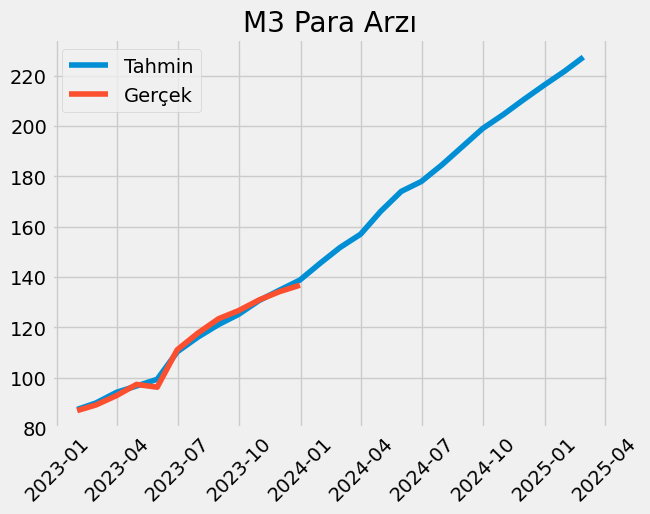

In [119]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [120]:
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-08-31,123.434020
2023-09-30,126.661059
2023-10-31,130.934676
2023-11-30,134.161244


In [121]:
m3tahmin=(predictions["yhat"].tail(15).pct_change(periods=1)*100).dropna()
m3tahmin1 = []
result = m3.iloc[-1,0]
for i in range(len(m3tahmin)):
    result *= (1 + m3tahmin[i] / 100)
    m3tahmin1.append(result)

m3tahmin1 = np.array(m3tahmin1).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-01-30", end="2025-03-27", freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,136.764707
2024-01-31,143.483501
2024-02-29,149.475070
2024-03-31,154.719091
2024-04-30,163.629197
2024-05-31,171.473793
2024-06-30,175.337608
2024-07-31,181.872823


In [122]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [123]:
#study.best_params

In [124]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=15,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:32 - cmdstanpy - INFO - Chain [1] start processing


13:42:32 - cmdstanpy - INFO - Chain [1] done processing


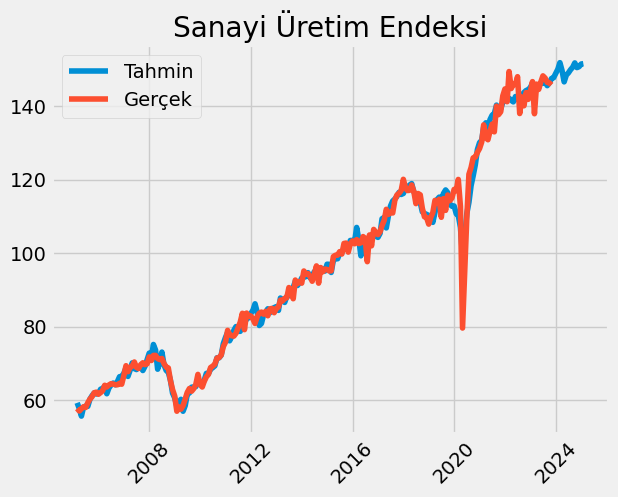

In [125]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [126]:
sanayitahmin=(predictions["yhat"].tail(16).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-11-30,109.610044
2023-12-31,110.469546
2024-01-31,111.343201
2024-02-29,112.649241
2024-03-31,111.033058
2024-04-30,108.774930
2024-05-31,110.144998
2024-06-30,110.588026
2024-07-31,111.225017
2024-08-31,111.732589


In [127]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [128]:
#study.best_params

In [129]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:33 - cmdstanpy - INFO - Chain [1] start processing


13:42:33 - cmdstanpy - INFO - Chain [1] done processing


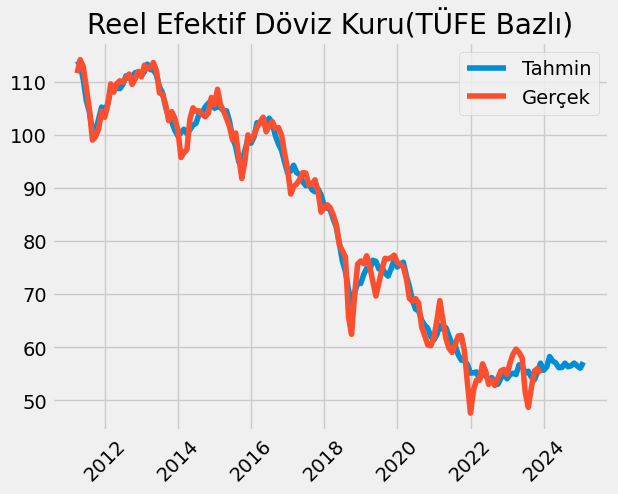

In [130]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [131]:
predictions["yhat"].tail(15)

ds
2023-11-30    57.016442
2023-12-31    55.680358
2024-01-31    56.309661
2024-02-29    58.274112
2024-03-31    57.428478
2024-04-30    57.089969
2024-05-31    56.172834
2024-06-30    56.211509
2024-07-31    57.022767
2024-08-31    56.360198
2024-09-30    56.528234
2024-10-31    57.037651
2024-11-30    56.514103
2024-12-31    56.071645
2025-01-31    57.206708
Name: yhat, dtype: float64

In [132]:
redkttahmin=predictions["yhat"].tail(27)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-12-31,55.124752
2024-01-31,54.100201
2024-02-29,54.903269
2024-03-31,55.120650
2024-04-30,54.896201
2024-05-31,56.713874
2024-06-30,56.546257
2024-07-31,55.152070
2024-08-31,55.504813
2024-09-30,54.386131


In [133]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [134]:
#study.best_params

In [135]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:42:34 - cmdstanpy - INFO - Chain [1] start processing


13:42:34 - cmdstanpy - INFO - Chain [1] done processing


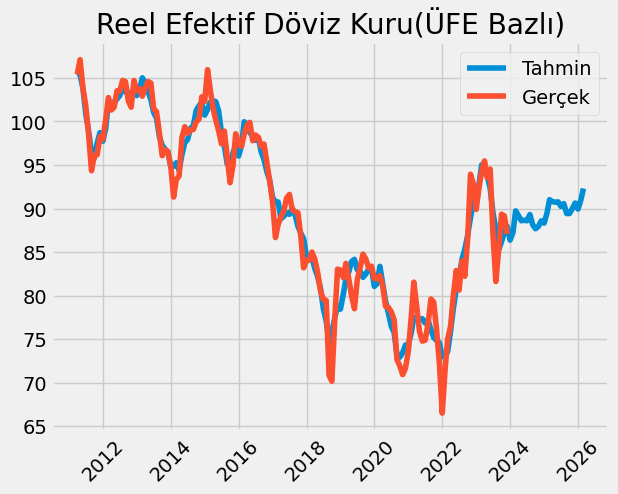

In [136]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [137]:
redktahmin=predictions["yhat"].tail(27)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-12-31,86.373456
2024-01-31,87.239667
2024-02-29,89.729383
2024-03-31,89.170241
2024-04-30,88.597250
2024-05-31,88.653628
2024-06-30,88.593602
2024-07-31,89.307854
2024-08-31,88.121405
2024-09-30,87.675159


In [248]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin1["Sanayi"],kreditahmin1.rolling(2).mean(),m3tahmin1.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf=tahmindf.iloc[:19]
tahmindf["Politika Faizi"]=[40,40,40,40,40,42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





tahmindf.iloc[0,1]=-3.23
#tahmindf.iloc[0,0]=2.42
tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-12-31,2.410119,-3.230000,3.837414,59.530000,0.0,0.784145,3.360000,2.245991,8.038963,2.187168,52.170000,2.464258,55.124752,86.373456,8.454193,42.5
2024-01-31,2.108947,5.837052,2.255112,59.851654,40.0,0.790856,2.395268,1.834769,2.972785,2.570612,53.302938,1.940548,54.100201,87.239667,8.347127,45.0
2024-02-29,1.847049,-2.473690,1.093496,59.964112,0.0,1.172986,2.705154,4.033778,3.625007,3.233079,51.170984,4.912666,54.903269,89.729383,8.364339,45.0
2024-03-31,2.055098,2.587696,2.545369,60.003430,0.0,-1.434704,2.729013,2.201972,3.701697,3.224428,52.815021,4.175790,55.120650,89.170241,8.439923,45.0
2024-04-30,2.133044,1.626967,-2.901185,60.017176,0.0,-2.033743,2.666159,3.665655,3.780794,3.877558,52.842752,3.508291,54.896201,88.597250,8.466738,45.0
2024-05-31,2.465993,4.428495,-2.657283,60.021983,0.0,1.259544,1.887541,3.593094,3.939096,3.748735,52.121114,5.758893,56.713874,88.653628,8.534691,45.0
2024-06-30,2.453150,-0.803615,6.315988,60.023663,0.0,0.402223,1.270527,3.546345,2.571142,3.128552,52.499256,4.794129,56.546257,88.593602,8.602699,45.0
2024-07-31,2.264443,0.936859,1.493700,60.024250,0.0,0.576003,1.320320,2.731369,3.410988,2.968103,52.605040,2.253298,55.152070,89.307854,8.653981,45.0
2024-08-31,2.092864,4.092941,-0.782232,60.024456,0.0,0.456347,1.879789,2.958223,3.048816,2.899007,52.385326,3.727218,55.504813,88.121405,8.715422,45.0
2024-09-30,2.284080,4.358014,-1.221874,60.024528,0.0,0.778023,2.188238,2.707098,2.722594,2.461497,52.458618,3.965546,54.386131,87.675159,8.774888,45.0


In [249]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi']


In [250]:
df6.to_csv('df6.csv')

In [251]:
import keras
import keras.optimizers
prediction_list=[]
for i in range(10):
   keras.utils.set_random_seed(i)
   X = data.drop(['TÜFE'], axis=1).values
   y = data['TÜFE'].values
   X=data[features].values

   X_scaled = scaler.fit_transform(X)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))

   model = tf.keras.Sequential()
   model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(9,1)))
   model.add(tf.keras.layers.Dense(64,activation='selu'))
   model.add(tf.keras.layers.Dense(64,activation='elu'))
   model.add(tf.keras.layers.Dense(1))
   rms = keras.optimizers.RMSprop(learning_rate=0.01)
   model.compile(optimizer=rms, loss='mean_squared_error')
   model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)
   tahmin=tahmindf[features].values
   X_scaled = scaler.fit_transform(X)
   tahmin_scaled = scaler.transform(tahmin)
   pred = model.predict(tahmin_scaled)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))
   pred = scaler.inverse_transform(pred)
   prediction_list.append(pred)
columns = [f'Prediction_{i+1}' for i in range(10)]
predictions_df = pd.DataFrame(np.column_stack(prediction_list), columns=columns)

Epoch 1/100
4/4 [==============================] - 2s 13ms/step - loss: 6.7595
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0240
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0196
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0189
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0177
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0162
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0169
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0846
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0186
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 12/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0167
Epoch 13/100
4/4 [==============================]

In [252]:
pred=predictions_df.iloc[:,:11].mean(axis=1).values
pred

array([3.1664274, 4.1829557, 2.9023883, 3.0084596, 3.1203659, 3.129729 ,
       2.7155206, 2.772718 , 2.9211068, 2.9136224, 2.8907497, 2.6725135,
       2.5456357, 3.438287 ], dtype=float32)

In [253]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669236
Enflasyon Belirsizliği    0.624443
REDKT                     0.578101
Kredi                     0.521249
Kredi Faizi               0.520287
Borç                      0.450264
Mevduat Faizi             0.423982
Zam                       0.407074
REDK                      0.388566
Politika Faizi            0.225434
İşsizlik                  0.194010
Perakende Satış           0.113209
Sanayi                    0.049493
Name: TÜFE, dtype: float64

In [254]:
tahmindf.columns

Index(['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'M3', 'REDKT', 'REDK', 'İşsizlik', 'Politika Faizi'],
      dtype='object')

In [255]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']


X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-12-31,1852.056478
2024-01-31,1944.317960
2024-02-29,1995.398945
2024-03-31,2053.629610
2024-04-30,2115.989994
2024-05-31,2184.867519
2024-06-30,2242.508419
2024-07-31,2302.809669
2024-08-31,2373.307706
2024-09-30,2447.486186


In [256]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi']






X= data[features]
y=data[["TÜFE"]]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-12-31,1851.822979
2024-01-31,1940.903448
2024-02-29,1989.983442
2024-03-31,2046.090990
2024-04-30,2106.038669
2024-05-31,2172.260911
2024-06-30,2226.421626
2024-07-31,2283.140757
2024-08-31,2350.264233
2024-09-30,2420.984405


In [257]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi']





X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-12-31,1851.679980
2024-01-31,1940.604434
2024-02-29,1989.634624
2024-03-31,2045.618912
2024-04-30,2105.446336
2024-05-31,2171.577613
2024-06-30,2225.609761
2024-07-31,2282.193475
2024-08-31,2349.160728
2024-09-30,2419.677341


In [258]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']







X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-12-31,1849.301431
2024-01-31,1936.588836
2024-02-29,1983.778284
2024-03-31,2037.587209
2024-04-30,2095.055090
2024-05-31,2158.672827
2024-06-30,2210.563562
2024-07-31,2264.949373
2024-08-31,2329.417282
2024-09-30,2397.426717


In [259]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']




X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-12-31,1851.414791
2024-01-31,1940.769413
2024-02-29,1990.138023
2024-03-31,2046.314983
2024-04-30,2106.372774
2024-05-31,2172.793486
2024-06-30,2227.365636
2024-07-31,2284.529344
2024-08-31,2351.962573
2024-09-30,2422.958201


In [260]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT']





X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-12-31,1851.417426
2024-01-31,1940.776305
2024-02-29,1990.148361
2024-03-31,2046.329230
2024-04-30,2106.391205
2024-05-31,2172.816689
2024-06-30,2227.393494
2024-07-31,2284.562290
2024-08-31,2352.000698
2024-09-30,2423.001413


In [261]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'M3', 'REDKT']

X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-12-31,1854.306755
2024-01-31,1950.044107
2024-02-29,2005.093300
2024-03-31,2068.683778
2024-04-30,2134.392973
2024-05-31,2210.065865
2024-06-30,2273.143362
2024-07-31,2337.481546
2024-08-31,2413.805700
2024-09-30,2494.314287


In [262]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=14,freq="1M"))
pred1=pred1[0]

In [263]:



tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin19

,LSTM
2023-12-31,1863.701511
2024-01-31,1941.659320
2024-02-29,1998.013813
2024-03-31,2058.123251
2024-04-30,2122.344226
2024-05-31,2188.767850
2024-06-30,2248.204292
2024-07-31,2310.540656
2024-08-31,2378.034017
2024-09-30,2447.320948


In [264]:
features=['USD/TL', 'Motorin',  'Zam', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT']
X = data[features]
y=data[["TÜFE"]]
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())

# Modeli uydurun
results = model.fit()

robusttahmin=results.predict(tahmindf[features])

tüfetahmin21 = []
result = 1806.50
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin21

,Robust Regression
2023-12-31,1853.375609
2024-01-31,1954.114296
2024-02-29,2008.535684
2024-03-31,2069.947280
2024-04-30,2134.984571
2024-05-31,2203.993692
2024-06-30,2265.359172
2024-07-31,2328.309621
2024-08-31,2401.655074
2024-09-30,2480.006324


In [265]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2023-12-31,1852.056478,1851.822979,1851.679980,1849.301431,1851.414791,1851.417426,1854.306755,1863.701511,1853.375609,1853.230773
2024-01-31,1944.317960,1940.903448,1940.604434,1936.588836,1940.769413,1940.776305,1950.044107,1941.659320,1954.114296,1943.308680
2024-02-29,1995.398945,1989.983442,1989.634624,1983.778284,1990.138023,1990.148361,2005.093300,1998.013813,2008.535684,1994.524942
2024-03-31,2053.629610,2046.090990,2045.618912,2037.587209,2046.314983,2046.329230,2068.683778,2058.123251,2069.947280,2052.480583
2024-04-30,2115.989994,2106.038669,2105.446336,2095.055090,2106.372774,2106.391205,2134.392973,2122.344226,2134.984571,2114.112871
2024-05-31,2184.867519,2172.260911,2171.577613,2158.672827,2172.793486,2172.816689,2210.065865,2188.767850,2203.993692,2181.757384
2024-06-30,2242.508419,2226.421626,2225.609761,2210.563562,2227.365636,2227.393494,2273.143362,2248.204292,2265.359172,2238.507703
2024-07-31,2302.809669,2283.140757,2282.193475,2264.949373,2284.529344,2284.562290,2337.481546,2310.540656,2328.309621,2297.612970
2024-08-31,2373.307706,2350.264233,2349.160728,2329.417282,2351.962573,2352.000698,2413.805700,2378.034017,2401.655074,2366.623112
2024-09-30,2447.486186,2420.984405,2419.677341,2397.426717,2422.958201,2423.001413,2494.314287,2447.320948,2480.006324,2439.241758


In [266]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [267]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"LSTM":df.iloc[-1,0],"Robust Regression":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin.iloc[1,:10]=tüfetahmin.iloc[1,:10]+9
tüfetahmin.iloc[2:,:10]=tüfetahmin.iloc[2:,:10]+10
tüfetahmin.iloc[1,-3]=tüfetahmin.iloc[1,-3]-9
tüfetahmin.iloc[2,-3]=tüfetahmin.iloc[2,-3]-10
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Ortalama
2023-11-30,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000
2023-12-31,1861.056478,1860.679980,1858.301431,1860.417426,1860.414791,1863.306755,1860.822979,1863.701511,1862.375609,1861.330773
2024-01-31,1954.317960,1950.604434,1946.588836,1950.776305,1950.769413,1960.044107,1950.903448,1941.659320,1964.114296,1952.308680
2024-02-29,2005.398945,1999.634624,1993.778284,2000.148361,2000.138023,2015.093300,1999.983442,2008.013813,2018.535684,2004.524942
2024-03-31,2063.629610,2055.618912,2047.587209,2056.329230,2056.314983,2078.683778,2056.090990,2068.123251,2079.947280,2062.480583
2024-04-30,2125.989994,2115.446336,2105.055090,2116.391205,2116.372774,2144.392973,2116.038669,2132.344226,2144.984571,2124.112871
2024-05-31,2194.867519,2181.577613,2168.672827,2182.816689,2182.793486,2220.065865,2182.260911,2198.767850,2213.993692,2191.757384
2024-06-30,2252.508419,2235.609761,2220.563562,2237.393494,2237.365636,2283.143362,2236.421626,2258.204292,2275.359172,2248.507703
2024-07-31,2312.809669,2292.193475,2274.949373,2294.562290,2294.529344,2347.481546,2293.140757,2320.540656,2338.309621,2307.612970
2024-08-31,2383.307706,2359.160728,2339.417282,2362.000698,2361.962573,2423.805700,2360.264233,2388.034017,2411.655074,2376.623112


In [268]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[5,:]=aylıktahmin.iloc[5,:]+0.50
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Ortalama
2023-12-31,3.020010,2.999169,2.867502,2.984635,2.984489,3.144575,3.007084,3.166427,3.093031,3.035194
2024-01-31,5.011212,4.832881,4.750973,4.856914,4.856692,5.191703,4.840894,4.182956,5.462845,4.887788
2024-02-29,2.613750,2.513590,2.424212,2.530893,2.530725,2.808569,2.515757,3.417412,2.770785,2.674590
2024-03-31,2.903695,2.799726,2.698842,2.808835,2.808654,3.155709,2.805401,2.993477,3.042383,2.891241
2024-04-30,3.021879,2.910434,2.806615,2.920835,2.920651,3.161096,2.915614,3.105278,3.126872,2.988260
2024-05-31,3.739786,3.626115,3.522141,3.638620,3.638422,4.028872,3.629538,3.615052,3.717232,3.684601
2024-06-30,2.626168,2.476747,2.392742,2.500293,2.500106,2.841244,2.481862,2.703170,2.771710,2.589261
2024-07-31,2.677071,2.531019,2.449190,2.555152,2.554956,2.817965,2.536156,2.760440,2.766616,2.628644
2024-08-31,3.048156,2.921536,2.833817,2.939053,2.938870,3.251321,2.927142,2.908519,3.136687,2.990542
2024-09-30,3.112417,2.989055,2.907110,3.005957,3.005790,3.321578,2.996282,2.901421,3.248858,3.055539


In [269]:
aylıktahmin.to_csv('modelaylık.csv')

In [270]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [271]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [272]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [273]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [274]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [275]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [276]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [277]:
tüfe = 1806.50# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [278]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [279]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [280]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)

In [281]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

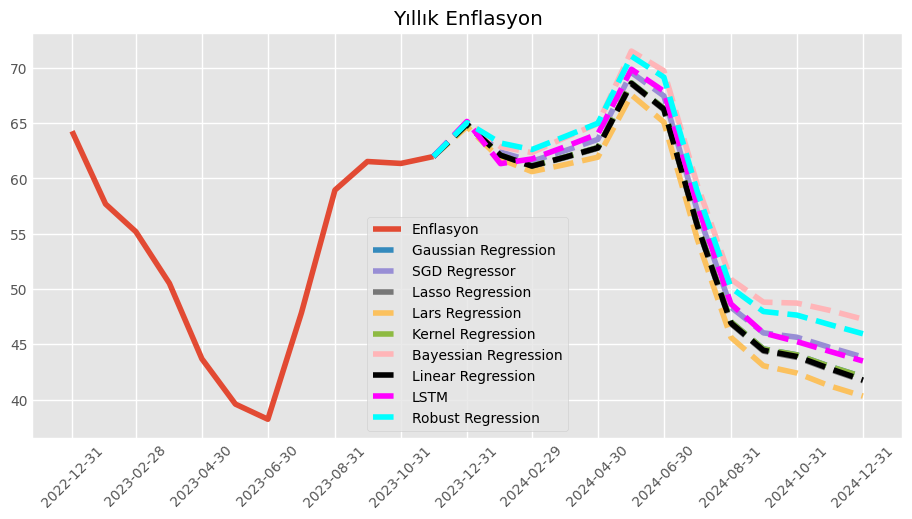

In [282]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:-1],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-1],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-1],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-1],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:-1],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-1],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-1],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:-1],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:-1],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [283]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [284]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:11].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:11].min(axis=1)
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:11].mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.iloc[:,1:11].median(axis=1)
yıllıktahmin.iloc[11:-1].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum,Medyan
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [285]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]


In [286]:
min1=str(yıllıktahmin.iloc[36,-2])[:2]
max1=str(yıllıktahmin.iloc[36,-3]+1)[:2]

In [287]:
min1

'40'

In [288]:
df.iloc[-25:,0].shift(12).dropna()

2022-11-30     604.84
2022-12-31     686.95
2023-01-31     763.23
2023-02-28     799.93
2023-03-31     843.64
2023-04-30     904.79
2023-05-31     931.76
2023-06-30     977.90
2023-07-31    1001.03
2023-08-31    1015.65
2023-09-30    1046.89
2023-10-31    1084.00
2023-11-30    1115.26
Freq: M, Name: CPI, dtype: float64

In [289]:
cariay=evds.get_data(["TP.BEK.S01.A.U"],startdate="01-11-2022",enddate="31-12-2023")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=14,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1806.50
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1128.45
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,1084.00,84.848489,604.84
2022-12-31,1.0269,1115.26,66.716718,686.95
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [290]:
ay1sonra=evds.get_data(["TP.BEK.S01.B.U"],startdate="01-12-2023",enddate="31-12-2023")
ay1sonra["TÜFE"]=1866.34
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_BEK_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-01-31"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_BEK_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,4.86,1866.34,1957.044124,1203.48,62.615426


In [291]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-12-2023",enddate="31-12-2023")
ay2sonra["TÜFE"]=ay1sonra["TÜFE Yeni"]
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-02-28"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,3.25,1957.044124,2020.648058,1241.33,62.780893


In [292]:
ay12sonra=evds.get_data(["TP.BEK.S01.E.U"],startdate="01-12-2023",enddate="31-12-2023")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2023-12,41.23


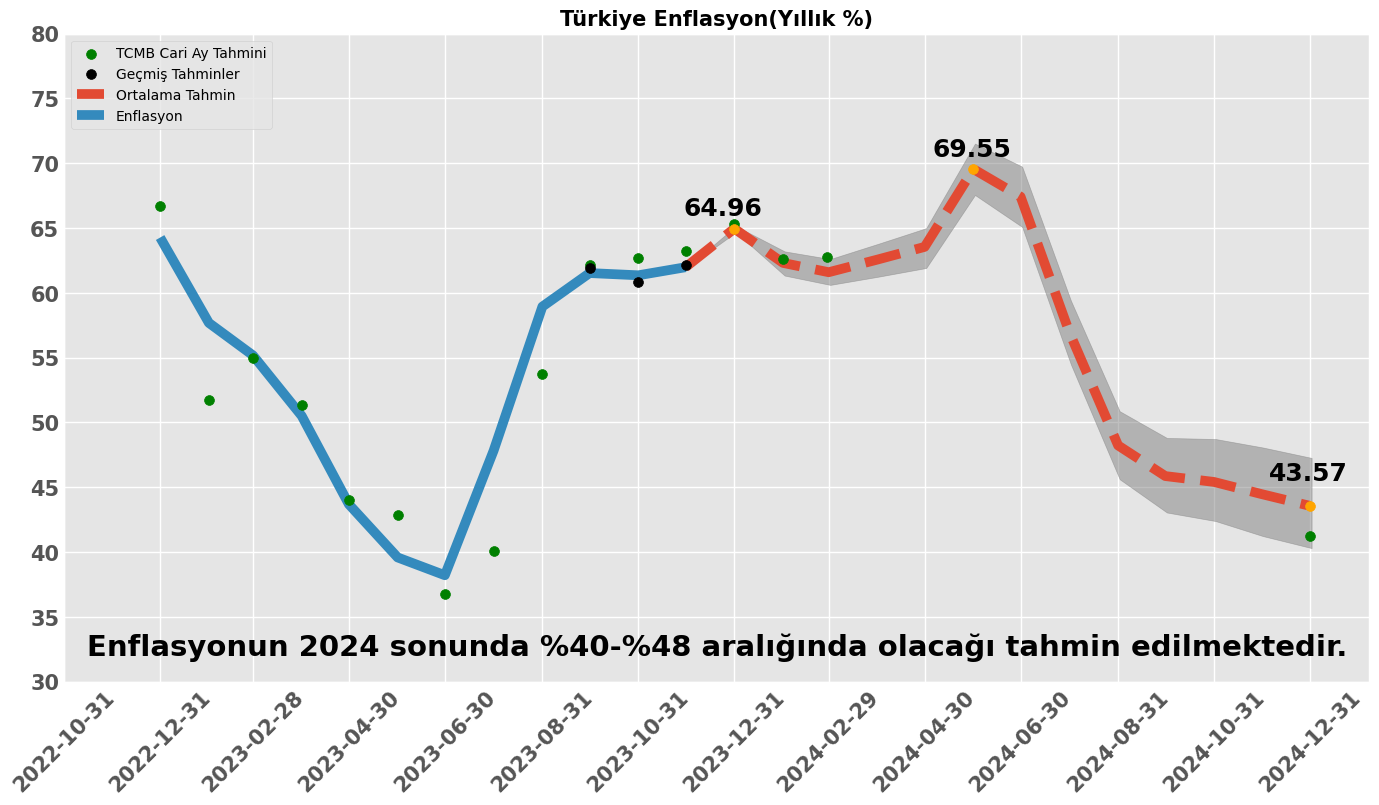

In [307]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-01-31"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-02-28"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[1:].index,y=cariay["Enflasyon"][1:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[21:24],y=[61.94,60.84,62.13],color='black',zorder=3,label='Geçmiş Tahminler',s=50)
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[23:37],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[23:39].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[23:39].shift(1), yıllıktahmin["Minimum"].iloc[23:39].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-01')
plt.text(mdates.datestr2num('2023-12'), float(sonu2023)+1, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[10:37:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2]),
 [Text(0, 0, '2023-09'), Text(1, 0, '2023-10'), Text(2, 0, '2023-11')])

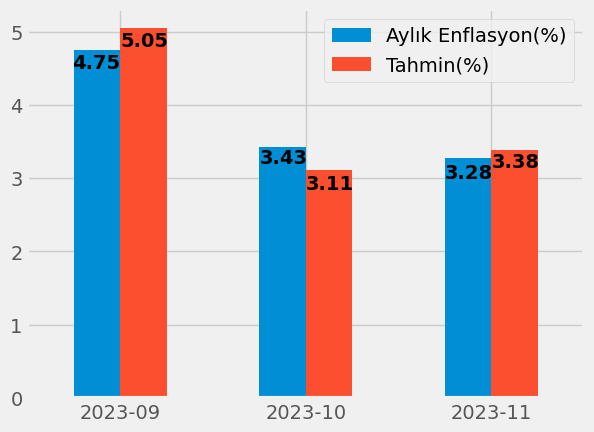

In [294]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28],"Tahmin(%)":[5.05,3.11,3.38]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=3,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar")
plt.annotate("4.75",xy=(-0.26,4.5),fontweight="bold")
plt.annotate("5.05",xy=(0,4.8),fontweight="bold")
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold")
plt.annotate("3.11",xy=(1,2.85),fontweight="bold")
plt.annotate("3.28",xy=(1.75,3),fontweight="bold")
plt.annotate("3.38",xy=(2,3.15),fontweight="bold")
plt.legend()
plt.xticks(rotation=0)

In [295]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


Text(17555.0, 5, 'Değişkenler:USD/TL,Politika Faizi,Mevduat Faizi,TÜFE,Yıllık Enflasyon.')

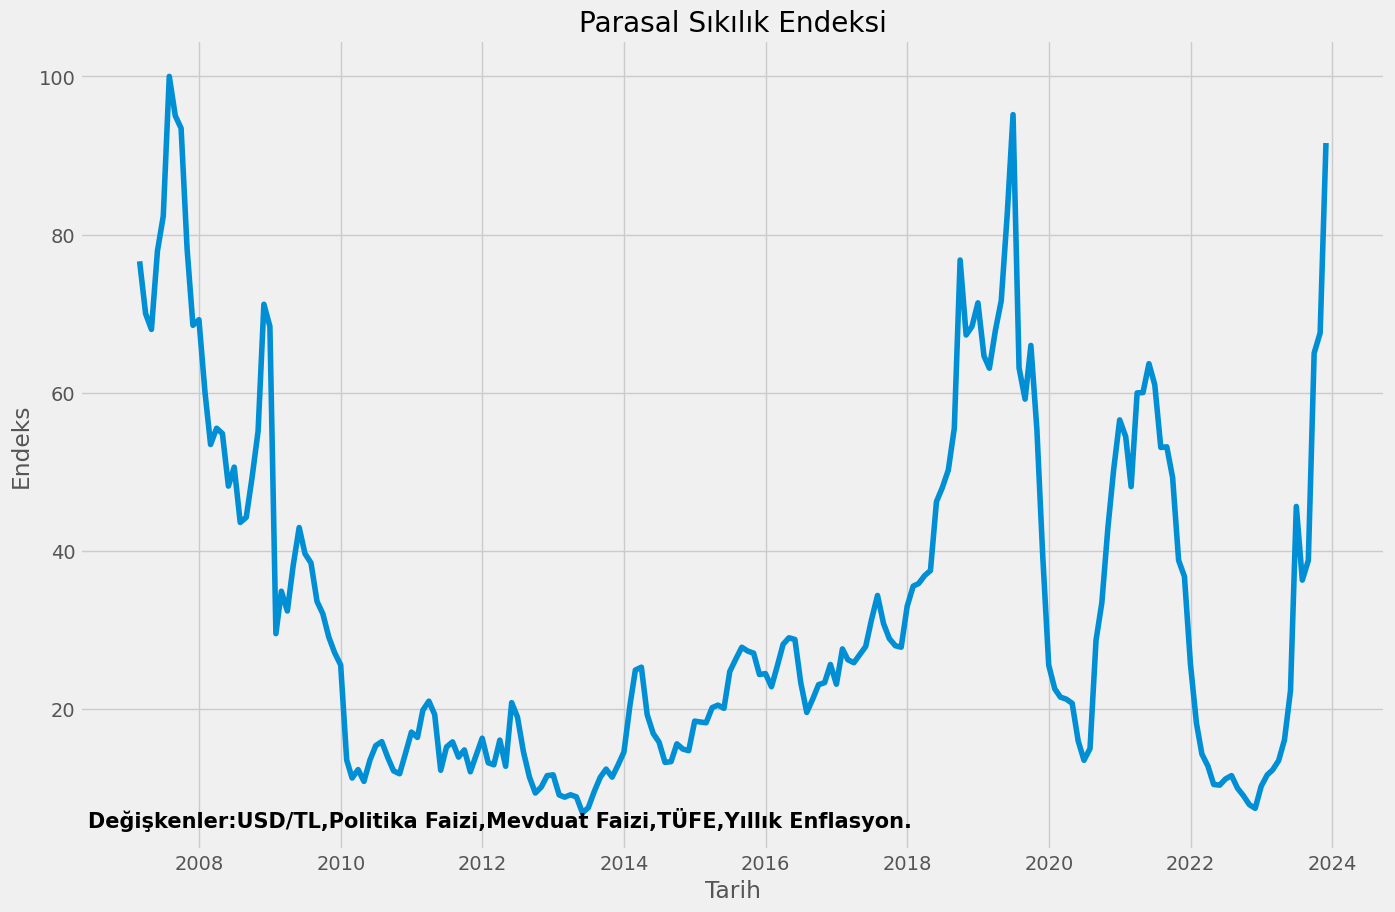

In [296]:
pfaiz.iloc[-1,0]=42.5
endeks=(df6["USD/TL"]*mfaiz["Mevduat Faizi"]*pfaiz["Politika Faizi"])/(df["CPI"]*df["Enflasyon"])
endeks=endeks*(100/endeks.max())
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,10))
plt.plot(endeks)
plt.title("Parasal Sıkılık Endeksi")
plt.xlabel("Tarih")
plt.ylabel("Endeks")
annotation_date = mdates.datestr2num('2018-01')
plt.text(annotation_date, 5, "Değişkenler:USD/TL,Politika Faizi,Mevduat Faizi,TÜFE,Yıllık Enflasyon.", fontsize=15, color='black', horizontalalignment='right',fontweight='bold')




In [297]:
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Ortalama
2023-12-31,3.020010,2.999169,2.867502,2.984635,2.984489,3.144575,3.007084,3.166427,3.093031,3.035194
2024-01-31,5.011212,4.832881,4.750973,4.856914,4.856692,5.191703,4.840894,4.182956,5.462845,4.887788
2024-02-29,2.613750,2.513590,2.424212,2.530893,2.530725,2.808569,2.515757,3.417412,2.770785,2.674590
2024-03-31,2.903695,2.799726,2.698842,2.808835,2.808654,3.155709,2.805401,2.993477,3.042383,2.891241
2024-04-30,3.021879,2.910434,2.806615,2.920835,2.920651,3.161096,2.915614,3.105278,3.126872,2.988260
2024-05-31,3.739786,3.626115,3.522141,3.638620,3.638422,4.028872,3.629538,3.615052,3.717232,3.684601
2024-06-30,2.626168,2.476747,2.392742,2.500293,2.500106,2.841244,2.481862,2.703170,2.771710,2.589261
2024-07-31,2.677071,2.531019,2.449190,2.555152,2.554956,2.817965,2.536156,2.760440,2.766616,2.628644
2024-08-31,3.048156,2.921536,2.833817,2.939053,2.938870,3.251321,2.927142,2.908519,3.136687,2.990542
2024-09-30,3.112417,2.989055,2.907110,3.005957,3.005790,3.321578,2.996282,2.901421,3.248858,3.055539


In [298]:
aylıktahmin.iloc[:-1,:-1]

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression
2023-12-31,3.020010,2.999169,2.867502,2.984635,2.984489,3.144575,3.007084,3.166427,3.093031
2024-01-31,5.011212,4.832881,4.750973,4.856914,4.856692,5.191703,4.840894,4.182956,5.462845
2024-02-29,2.613750,2.513590,2.424212,2.530893,2.530725,2.808569,2.515757,3.417412,2.770785
2024-03-31,2.903695,2.799726,2.698842,2.808835,2.808654,3.155709,2.805401,2.993477,3.042383
2024-04-30,3.021879,2.910434,2.806615,2.920835,2.920651,3.161096,2.915614,3.105278,3.126872
2024-05-31,3.739786,3.626115,3.522141,3.638620,3.638422,4.028872,3.629538,3.615052,3.717232
2024-06-30,2.626168,2.476747,2.392742,2.500293,2.500106,2.841244,2.481862,2.703170,2.771710
2024-07-31,2.677071,2.531019,2.449190,2.555152,2.554956,2.817965,2.536156,2.760440,2.766616
2024-08-31,3.048156,2.921536,2.833817,2.939053,2.938870,3.251321,2.927142,2.908519,3.136687
2024-09-30,3.112417,2.989055,2.907110,3.005957,3.005790,3.321578,2.996282,2.901421,3.248858


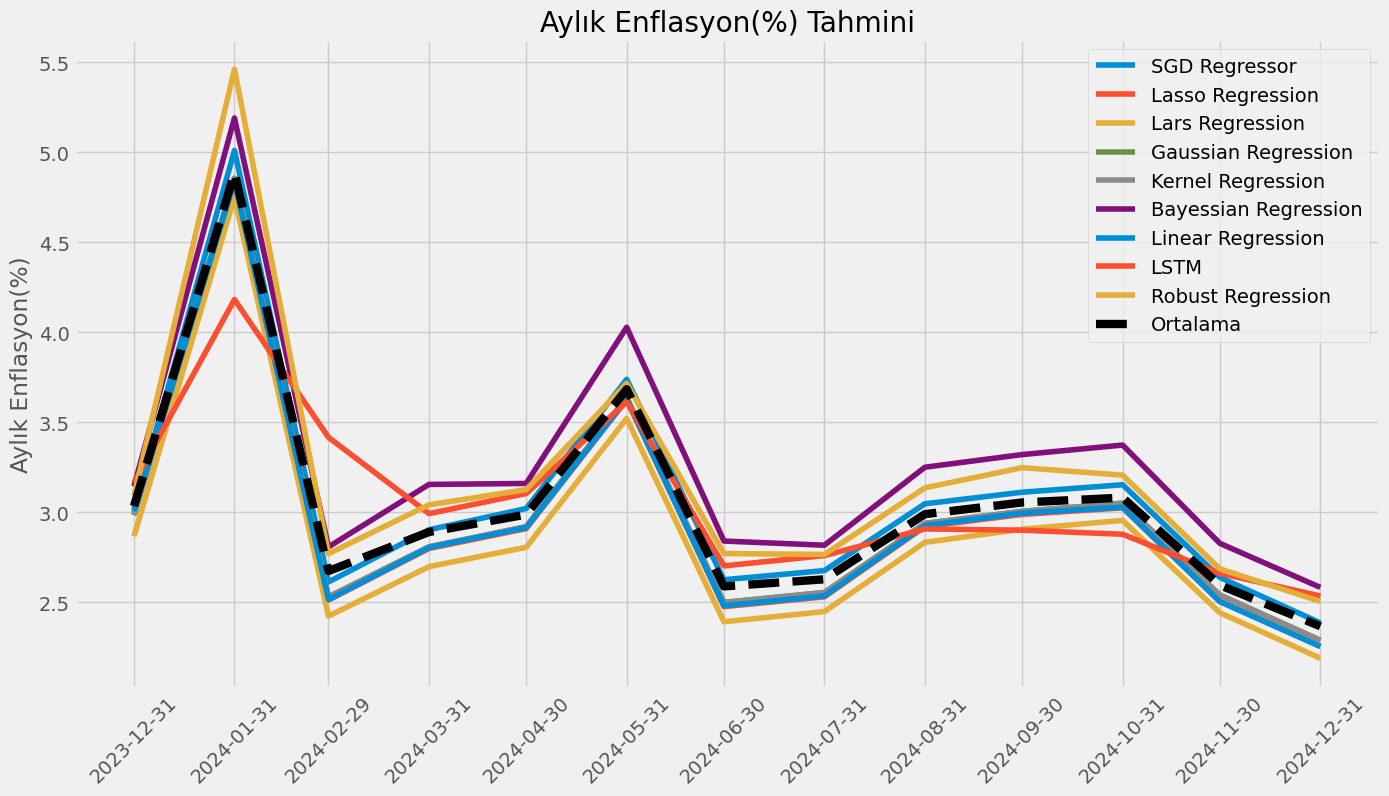

In [299]:
plt.figure(figsize=(15,8))
plt.plot(aylıktahmin.iloc[:-1,:-1],label=aylıktahmin.columns[:-1])
plt.xticks(aylıktahmin.index[:-1],rotation=45)
plt.plot(aylıktahmin["Ortalama"][:-1],"--",label="Ortalama",linewidth=6,color="black")
plt.legend()
plt.title("Aylık Enflasyon(%) Tahmini")
plt.ylabel("Aylık Enflasyon(%)")
plt.show()

In [300]:
endeksc=evds.get_data(["TP.FE.OKTG04"],startdate="01-01-2003",enddate=date.today().strftime("%d-%m-%Y"))
del endeksc["Tarih"]
endeksc=endeksc.set_index(pd.date_range(start="2003-01-30",periods=len(endeksc),freq="1M"))
endeksc.columns=["TÜFE C"]
from statsmodels.tsa.seasonal import seasonal_decompose
d=seasonal_decompose(endeksc["TÜFE C"])
endeksc["Mevsimsellikten Arındırılmış"]=endeksc["TÜFE C"]-d.seasonal
endeksc["Mevsimsellikten Arındırılmış Aylık"]=endeksc["Mevsimsellikten Arındırılmış"].pct_change(periods=1)*100
endeksc

,TÜFE C,Mevsimsellikten Arındırılmış,Mevsimsellikten Arındırılmış Aylık
2003-01-31,94.47,92.874206,NaN
2003-02-28,95.24,96.267289,3.653418
2003-03-31,96.01,98.548269,2.369423
2003-04-30,97.49,98.990685,0.448934
2003-05-31,98.80,99.375602,0.388841
...,...,...,...
2023-07-31,1174.19,1173.035102,9.756138
2023-08-31,1278.52,1279.124394,9.044000
2023-09-30,1346.08,1346.516373,5.268602
2023-10-31,1396.22,1395.173373,3.613547


In [301]:

endeksc["Aylık"]=endeksc["TÜFE C"].pct_change(periods=1)*100
endeksc


,TÜFE C,Mevsimsellikten Arındırılmış,Mevsimsellikten Arındırılmış Aylık,Aylık
2003-01-31,94.47,92.874206,NaN,NaN
2003-02-28,95.24,96.267289,3.653418,0.815074
2003-03-31,96.01,98.548269,2.369423,0.808484
2003-04-30,97.49,98.990685,0.448934,1.541506
2003-05-31,98.80,99.375602,0.388841,1.343728
...,...,...,...,...
2023-07-31,1174.19,1173.035102,9.756138,9.605242
2023-08-31,1278.52,1279.124394,9.044000,8.885274
2023-09-30,1346.08,1346.516373,5.268602,5.284235
2023-10-31,1396.22,1395.173373,3.613547,3.724890


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


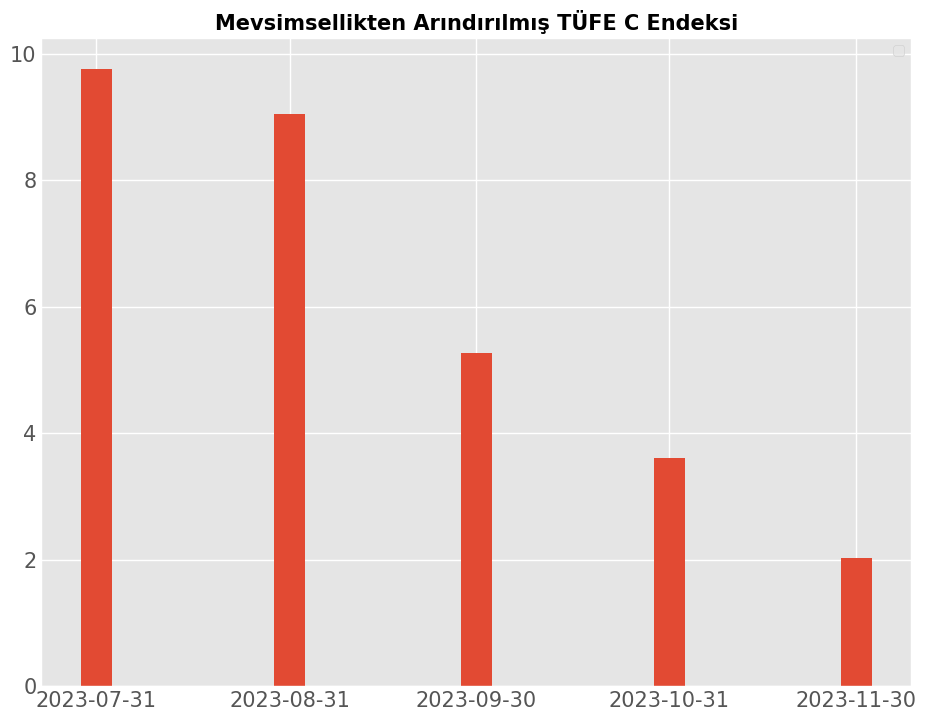

In [302]:
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.bar(endeksc.index[-5:],endeksc["Mevsimsellikten Arındırılmış Aylık"][-5:],width=5)
plt.xticks(endeksc.index[-5:],fontsize=15)
plt.yticks(fontsize=15)
plt.title("Mevsimsellikten Arındırılmış TÜFE C Endeksi",fontsize=15,fontweight="bold",color="black")
plt.legend()
plt.show()